In [28]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix, plot_roc_curve, recall_score, f1_score, precision_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from copy import deepcopy

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as iPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix, plot_confusion_matrix, plot_roc_curve, recall_score, f1_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb


In [29]:
df = pd.read_parquet('./Data/draft0522.parquet')

In [30]:
model_df = df.drop(['school_name'],axis=1)

In [31]:
model_df.Round.value_counts(normalize=True)

0.0    0.358002
1.0    0.349761
2.0    0.292237
Name: Round, dtype: float64

In [32]:
X = model_df.drop(['Round'],axis=1)
y = model_df.Round

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team
player_age = X_test.Age

X_train.drop(['player','pick','year','team','Age'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team','Age'],axis=1,inplace=True)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_name = X_test.player
player_pick = X_test.pick
player_year = X_test.year
player_team = X_test.team
player_age = X_test.Age

X_train.drop(['player','pick','year','team','Age'],axis=1,inplace=True)
X_test.drop(['player','pick','year','team','Age'],axis=1,inplace=True)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes('float64')

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[
    ('ss',StandardScaler()),
    ('impute',SimpleImputer(strategy='constant'))])

transformer = ColumnTransformer(transformers=[
    ('num', num_transformer, X_train_num.columns),
    ('cat', cat_transformer, X_train_cat.columns)])

pipe = Pipeline(steps=[
    ('trans',transformer),
    ('gaus',GaussianMixture(random_state=42))])

grid = {'gaus__n_components':[4,5]}

gridsearch = GridSearchCV(estimator=pipe,
                         param_grid=grid,
                         cv=5)

gridsearch.fit(X_train,y_train)

trans_train = gridsearch.predict(X_train)
trans_test = gridsearch.predict(X_test)
rfc = RandomForestClassifier(random_state=42)
rfc.fit(trans_train.reshape(-1,1),y_train)
y_preds = rfc.predict(trans_test.reshape(-1,1))

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

              precision    recall  f1-score   support

         0.0       0.35      0.59      0.44       717
         1.0       0.36      0.28      0.31       695
         2.0       0.34      0.15      0.21       591

    accuracy                           0.35      2003
   macro avg       0.35      0.34      0.32      2003
weighted avg       0.35      0.35      0.33      2003



C:\Users\capta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


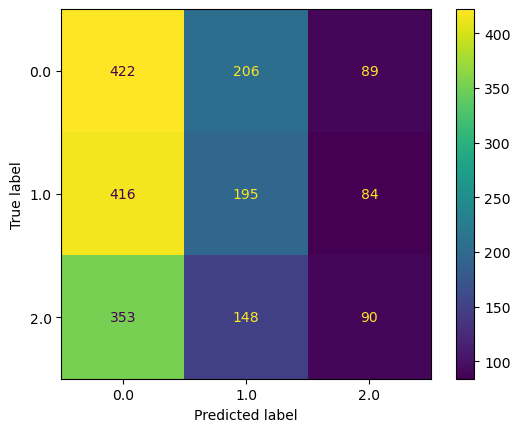

In [35]:
print(classification_report(y_test,y_preds))
plot_confusion_matrix(rfc,trans_test.reshape(-1,1),y_test)

In [36]:
preprocess = deepcopy(gridsearch.best_estimator_)
preprocess.steps.pop()
y_probs = pd.DataFrame(gridsearch.predict_proba(X_test))



C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [37]:
y_probs

,0,1,2,3
0,1.0,0.000000e+00,0.0,1.923523e-50
1,0.0,1.000000e+00,0.0,0.000000e+00
2,0.0,0.000000e+00,1.0,0.000000e+00
3,0.0,0.000000e+00,1.0,0.000000e+00
4,1.0,9.927473e-82,0.0,2.499562e-39
...,...,...,...,...
1998,0.0,1.000000e+00,0.0,0.000000e+00
1999,0.0,1.000000e+00,0.0,0.000000e+00
2000,0.0,0.000000e+00,1.0,0.000000e+00
2001,0.0,0.000000e+00,1.0,0.000000e+00


In [38]:
X_test

,pos,height,weight,forty_yd,vertical,bench_reps,broad_jump,cone,shuttle,g_season,...,tackles_total_career,tackles_loss_career,sacks_career,pass_defended_career,fumbles_forced_season,fumbles_forced_career,college_conference,speed,shuttle_agility,cone_agility
2763,DT,75.0,313.0,5.06,26.5,30.0,101.0,NaN,NaN,NaN,...,107.0,13.5,5.0,3.0,NaN,2.0,None,95.493160,NaN,NaN
3758,RB,72.0,238.0,4.64,NaN,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,102.691626,NaN,NaN
1652,WR,74.0,188.0,4.52,40.0,NaN,122.0,7.03,4.43,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,90.081188,97.627673,108.223573
3872,WR,73.0,199.0,4.54,32.5,17.0,116.0,NaN,NaN,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,93.682756,NaN,NaN
5143,LB,75.0,241.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,...,289.0,24.5,14.5,1.0,2.0,6.0,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,S,71.0,203.0,4.45,36.5,20.0,121.0,7.28,4.30,12.0,...,89.0,12.0,1.5,NaN,NaN,NaN,None,103.534714,118.755084,105.228140
4714,S,72.0,209.0,4.63,34.5,17.0,114.0,7.45,4.30,13.0,...,190.0,14.0,1.0,13.0,NaN,NaN,None,90.960391,122.265087,101.089829
2622,WR,74.0,206.0,4.58,NaN,NaN,NaN,NaN,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,Pacific Twelve Conference,93.634372,NaN,NaN
5693,TE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN


In [39]:
gridsearch.best_estimator_

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler()),
                                                                  ('impute',
                                                                   SimpleImputer(strategy='constant'))]),
                                                  Index(['height', 'weight', 'forty_yd', 'vertical', 'bench_reps', 'broad_jump',
       'cone', 'shuttle', 'g_season', 'def_int_season', 'def_int_yds_season',
       'def_int_yds_per_int_season', 'def_int_career', 'def_int_yds_...
       'tackles_loss_career', 'sacks_career', 'pass_defended_career',
       'fumbles_forced_season', 'fumbles_forced_career', 'speed',
       'shuttle_agility', 'cone_agility'],
      dtype='object')),
                                                 ('cat',
                                    

In [40]:
X_transformed = preprocess.transform(X_train)

In [41]:
gridsearch.best_estimator_[-1].aic(X_transformed)

-3030368.4708298845

In [42]:
gridsearch.best_estimator_[-1].bic(X_transformed)

-2784792.57801094

In [43]:
y_pred = gridsearch.predict_proba(X_test)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [44]:
y_pred_df = pd.DataFrame(y_pred)

In [45]:
from sklearn.manifold import TSNE

In [46]:
tsne = TSNE(random_state=42,learning_rate=100)
tsne_y_pred = tsne.fit_transform(y_pred_df)
tsne_y_pred = pd.DataFrame(tsne_y_pred, columns = ['TSNE1','TSNE2'])

C:\Users\capta\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [47]:
tsne_y_pred['group'] = np.argmax(y_pred_df.values, axis = 1)

In [48]:
tsne_x = transformer.fit_transform(X_test)
tsne_x = tsne.fit_transform(tsne_x)

C:\Users\capta\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [49]:
tsne_xs = pd.DataFrame(tsne_x, columns = ['TSNE1','TSNE2'])

In [50]:
x_tsne = pd.concat([tsne_xs,tsne_y_pred['group']],axis=1)

In [51]:
look = pd.concat([player_name.reset_index(),player_pick.reset_index(),player_team.reset_index(),player_year.reset_index(),y_test.reset_index(),X_test.reset_index(),tsne_y_pred.reset_index()],axis=1)

In [52]:
relook = pd.concat([player_name.reset_index(),player_pick.reset_index(),player_team.reset_index(),player_year.reset_index(),y_test.reset_index(),X_test.reset_index(),x_tsne.reset_index()],axis=1)

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

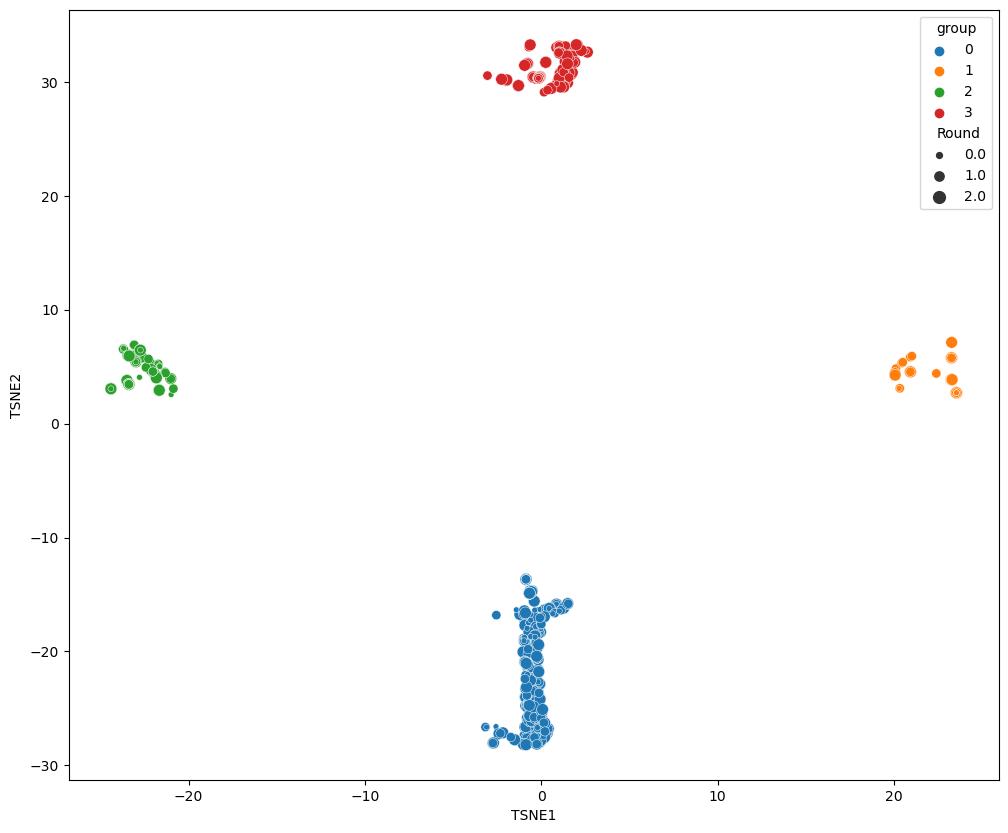

In [54]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=tsne_y_pred.TSNE1,y=tsne_y_pred.TSNE2, hue=tsne_y_pred['group'], palette = 'tab10',size=look.Round);

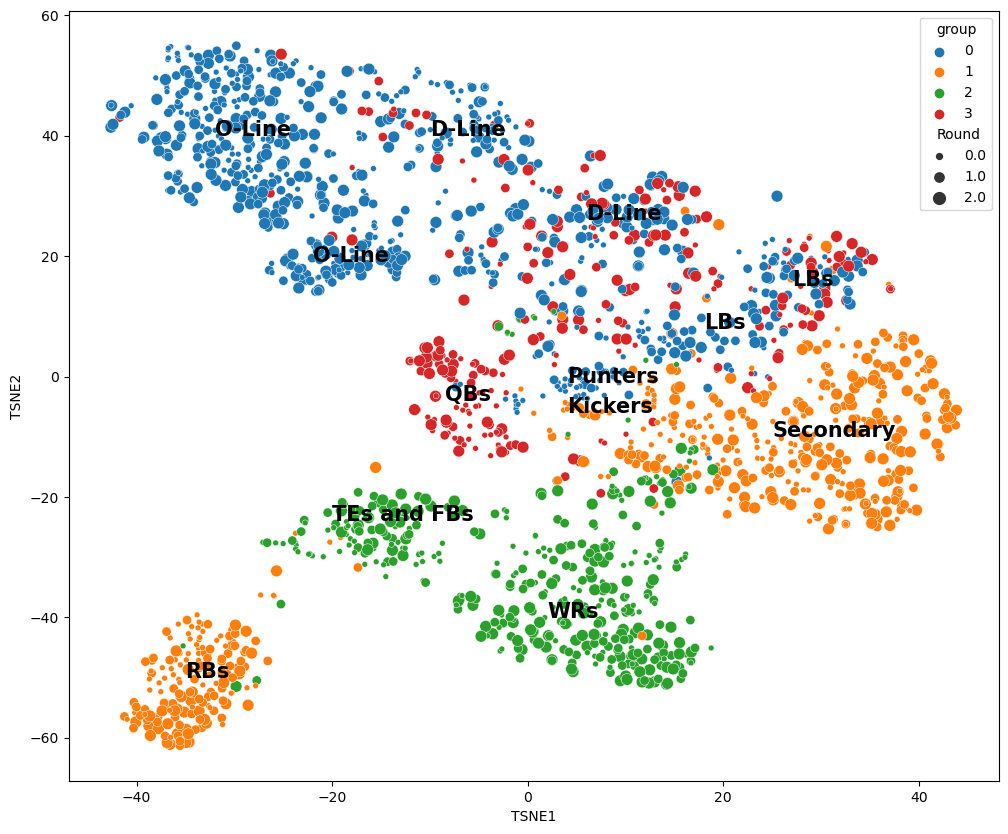

In [162]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=x_tsne.TSNE1,y=x_tsne.TSNE2, hue=x_tsne['group'], palette = 'tab10',size=look.Round)
plt.annotate(text='RBs',xy=(-35,-50),fontsize=15,weight='bold')
plt.annotate(text='Secondary',xy=(25,-10),fontsize=15,weight='bold')
plt.annotate(text='Kickers',xy=(4,-6),fontsize=15,weight='bold')
plt.annotate(text='TEs and FBs',xy=(-20,-24),fontsize=15,weight='bold')
plt.annotate(text='WRs',xy=(2,-40),fontsize=15,weight='bold')
plt.annotate(text='QBs',xy=(-8.5,-4),fontsize=15,weight='bold')
plt.annotate(text='LBs',xy=(27,15),fontsize=15,weight='bold')
plt.annotate(text='LBs',xy=(18,8),fontsize=15,weight='bold')
plt.annotate(text='D-Line',xy=(6,26),fontsize=15,weight='bold')
plt.annotate(text='Punters',xy=(4,-1),fontsize=15,weight='bold')
plt.annotate(text='O-Line',xy=(-22,19),fontsize=15,weight='bold')
plt.annotate(text='D-Line',xy=(-10,40),fontsize=15,weight='bold')
plt.annotate(text='O-Line',xy=(-32,40),fontsize=15,weight='bold');

In [151]:
relook.groupby('group').pos.value_counts()

group  pos 
0      OL      330
       LB      142
       DT      115
       DE       82
       DL       51
       P        36
       LS        9
       QB        9
       TE        3
       CB        1
1      CB      175
       RB      173
       S       144
       K        27
       DB       16
       LB        8
       WR        3
       LS        2
       QB        1
2      WR      292
       TE       98
       FB       23
3      QB       87
       LB       86
       DE       30
       DT       22
       EDGE     22
       WR        7
       FB        3
       OL        2
       TE        2
       DL        1
       RB        1
Name: pos, dtype: int64

In [154]:
relook[(relook.group == 0) & (relook.TSNE1 < -18 ) & (relook.TSNE2 > 22)].pos.value_counts()

OL    243
DT     36
DL      3
DE      2
QB      1
Name: pos, dtype: int64

In [152]:
relook[(relook.group == 0) & (relook.TSNE1 > -18 ) & (relook.TSNE2 > 30)].pos.value_counts()

DT    64
DL    28
DE    23
LB     2
LS     2
TE     1
Name: pos, dtype: int64

In [149]:
relook[(relook.group == 0) & (relook.TSNE1 < -10 ) & (relook.TSNE2 < 25)].pos.value_counts()

OL    83
DT     3
Name: pos, dtype: int64

In [145]:
relook[(relook.group == 0) & (relook.TSNE1 > -10 ) & (relook.TSNE2 > 15)].pos.value_counts()

DE    73
LB    60
DT    44
DL    38
LS     2
TE     1
Name: pos, dtype: int64

In [135]:
relook[(relook.group == 0) & (relook.TSNE2 < 5)].pos.value_counts()

P     36
LB    15
LS     7
QB     6
DE     2
OL     2
CB     1
Name: pos, dtype: int64

In [134]:
relook[(relook.group == 3) & (relook.TSNE2 > 15)].pos.value_counts()

LB      38
DE      27
DT      20
EDGE    19
OL       2
FB       2
DL       1
WR       1
Name: pos, dtype: int64

In [130]:
relook[(relook.group == 3) & (relook.TSNE1 > 20)].pos.value_counts()

LB    50
WR     2
Name: pos, dtype: int64

In [124]:
relook[(relook.group == 3) & (relook.TSNE1 < 5) & (relook.TSNE2 < 15)].pos.value_counts()

QB      85
WR       4
LB       3
TE       2
DT       1
DE       1
FB       1
EDGE     1
Name: pos, dtype: int64

In [123]:
relook[(relook.group == 2) & (relook.TSNE1 > 5) & (relook.TSNE2 > -25)].pos.value_counts()

WR    37
FB     1
TE     1
Name: pos, dtype: int64

In [115]:
relook[(relook.group == 2) & (relook.TSNE1 < -10) & (relook.TSNE2 > -32)].pos.value_counts()

TE    72
FB    17
WR     7
Name: pos, dtype: int64

In [106]:
relook[(relook.group == 1) & (relook.TSNE1 > 0) & (relook.TSNE1 < 10)].pos.value_counts()

K     14
S      7
DB     3
CB     1
LB     1
Name: pos, dtype: int64

In [104]:
relook[(relook.TSNE1 > 0) & (relook.group == 1)].pos.value_counts()

CB    173
S     143
K      27
DB     16
RB     12
LB      8
WR      3
Name: pos, dtype: int64

In [97]:
relook[(relook.TSNE1 > 0) & (relook.TSNE1 < 25) & (relook.TSNE2 > -25) & (relook.group == 1)].pos.value_counts()

S     52
CB    51
K     27
RB    12
DB     7
LB     5
WR     2
Name: pos, dtype: int64

In [93]:
relook[(relook.TSNE1 > 30) & (relook.TSNE2 > -17) & (relook.group == 1)].pos.value_counts()

S     77
CB    39
DB     2
LB     1
Name: pos, dtype: int64

group  pos 
0      OL      330
       LB      142
       DT      115
       DE       82
       DL       51
       P        36
       LS        9
       QB        9
       TE        3
       CB        1
1      CB      175
       RB      173
       S       144
       K        27
       DB       16
       LB        8
       WR        3
       LS        2
       QB        1
2      WR      292
       TE       98
       FB       23
3      QB       87
       LB       86
       DE       30
       DT       22
       EDGE     22
       WR        7
       FB        3
       OL        2
       TE        2
       DL        1
       RB        1
Name: pos, dtype: int64

In [76]:
group0.pos.value_counts(normalize=True)

OL    0.424165
LB    0.182519
DT    0.147815
DE    0.105398
DL    0.065553
P     0.046272
QB    0.011568
LS    0.011568
TE    0.003856
CB    0.001285
Name: pos, dtype: float64

In [77]:
group1.pos.value_counts(normalize=True)

CB    0.318761
RB    0.315118
S     0.262295
K     0.049180
DB    0.029144
LB    0.014572
WR    0.005464
LS    0.003643
QB    0.001821
Name: pos, dtype: float64

In [78]:
group2.pos.value_counts(normalize=True)

WR    0.707022
TE    0.237288
FB    0.055690
Name: pos, dtype: float64

In [79]:
group3.pos.value_counts(normalize=True)

QB      0.330798
LB      0.326996
DE      0.114068
DT      0.083650
EDGE    0.083650
WR      0.026616
FB      0.011407
OL      0.007605
TE      0.007605
DL      0.003802
RB      0.003802
Name: pos, dtype: float64

In [80]:
look.groupby('group').tackles_total_season.mean()

group
0    51.671554
1    57.887324
2          NaN
3    67.916667
Name: tackles_total_season, dtype: float64

In [81]:
look.groupby('group').bench_reps.mean()

group
0    24.634921
1    17.339024
2    16.532143
3    23.253623
Name: bench_reps, dtype: float64

In [82]:
look.groupby('group').weight.mean()

group
0    285.847742
1    204.364469
2    216.219512
3    243.456274
Name: weight, dtype: float64

In [83]:
look.groupby('group').height.mean()

group
0    75.497416
1    71.238532
2    73.578049
3    74.482890
Name: height, dtype: float64

In [84]:
look.groupby('group').rec_career.mean()

group
0           NaN
1     50.861446
2    118.905660
3           NaN
Name: rec_career, dtype: float64